In [1]:
def normalize(img1, img2):
    """
    Normalizza entrambe le immagini tra 0 e 1 in base all'immagine con il massimo valore (più rumorosa), media indefinita.
    """
    # Verifica che le patch non siano vuote prima della normalizzazione
    if img1.size > 0 and img2.size > 0:
        min_val = min(img1.min(), img2.min())
        max_val = max(img1.max(), img2.max())
    # Normalizzazione tra 0 e 1, commentare in caso
    if max_val != min_val:  # Evita divisione per zero
        img1_normalized = (img1 - min_val) / (max_val - min_val)
        img2_normalized = (img2 - min_val) / (max_val - min_val)
    return img1_normalized, img2_normalized

def antinormalize(img1_o, img2_o, img_n):
    """
    Riporta le immagini ad antinormalizzate, prende in input le originali _o e le normalizzate_n
    """
    # Verifica che le patch non siano vuote prima della normalizzazione
    if img1_o.size > 0 and img2_o.size > 0:
        min_val = min(img1_o.min(), img2_o.min())
        max_val = max(img1_o.max(), img2_o.max())
    # Normalizzazione tra 0 e 1, commentare in caso
    if max_val != min_val:  # Evita divisione per zero
        img_restored = (img_n) * (max_val - min_val) + min_val
    return img_restored

def normalize_2(img1, img2):
    """
    Normalizza entrambe le immagini tra 0 e 1 in base all'immagine con il massimo valore (più rumorosa), media indefinita.
    """
    # Verifica che le patch non siano vuote prima della normalizzazione
    if img1.size > 0 and img2.size > 0:
        max_val = max(abs(img1.max()), abs(img2.max()))
    # Normalizzazione tra 0 e 1, commentare in caso
    if max_val != 0:  # Evita divisione per zero
        img1_normalized = img1 / max_val
        img2_normalized = img2 / max_val
    return img1_normalized, img2_normalized

def antinormalize_2(img1_o, img2_o, img_n):
    """
    Riporta le immagini ad antinormalizzate, prende in input le originali _o e le normalizzate_n
    """
    # Verifica che le patch non siano vuote prima della normalizzazione
    if img1_o.size > 0 and img2_o.size > 0:
        max_val = max(abs(img1_o.max()), abs(img2_o.max()))
    # Normalizzazione tra 0 e 1, commentare in caso
    if max_val != 0:  # Evita divisione per zero
        img_restored = img_n * max_val
    return img_restored

In [2]:
import os
import torch
from pytorch_msssim import SSIM as _SSIM
from scipy.io import loadmat

# PSNR Class for 2D Tensors (images)
class PSNR(object):
    def __init__(self, data_range, reduction='none', eps=1e-8):
        self.data_range = data_range
        self.reduction = reduction
        self.eps = eps

    def __call__(self, outputs, targets):
        with torch.set_grad_enabled(False):
            # Calculate MSE between 2D images (no need for dim=(1, 2, 3))
            mse = torch.mean((outputs - targets) ** 2.)  # Now for 2D images
            psnr = 10. * torch.log10((self.data_range ** 2.) / (mse + self.eps))

            if self.reduction == 'mean':
                return psnr.mean()
            if self.reduction == 'sum':
                return psnr.sum()

            return psnr


# SSIM Class for 2D Tensors (images)
class SSIM(object):
    def __init__(self, channels, data_range, reduction='none'):
        self.data_range = data_range
        self.reduction = reduction
        self.ssim_module = _SSIM(data_range=data_range, size_average=False, channel=channels)

    def __call__(self, outputs, targets):
        with torch.set_grad_enabled(False):
            # Add batch and channel dimensions to make the input 4D
            outputs = outputs.unsqueeze(0).unsqueeze(0)  # Adding batch size and channel dimensions
            targets = targets.unsqueeze(0).unsqueeze(0)  # Same for targets

            # Convert tensors to double precision (float64) for SSIM calculation
            outputs = outputs.double()
            targets = targets.double()

            # Calculate SSIM
            ssim = self.ssim_module(outputs, targets)

            if self.reduction == 'mean':
                return ssim.mean()
            if self.reduction == 'sum':
                return ssim.sum()

            return ssim

In [30]:
import os
import numpy as np
import torch
from scipy.io import loadmat

# Define noise levels and indices
noise_levels = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 170, 200]
indices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]#, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# Initialize metrics
psnr_metric = PSNR(data_range=1.0, reduction='mean')
ssim_metric = SSIM(channels=1, data_range=1.0, reduction='mean')

# Dictionary to store results
psnr_results = {}
ssim_results = {}

# Loop over each noise level
for noise in noise_levels:
    psnr_results[noise] = []
    ssim_results[noise] = []

    print(f"Processing: Noise Level={noise}")
    
    for idx in indices:
        #print(f"Processing: Noise Level={noise}, Index={idx}")

        # Define file paths
        #off
        #folder = f'Dataset/off/test/perc{noise}/label'
        #folder2 = f'Dataset/off/test/perc{noise}/noisy'
        #folder3 = f'Results_ivs/RDUNet/off/pred{noise}'    
        #TA2
        #folder = f'Dataset/TA/TA2/test/perc{noise}/label'
        #folder2 = f'Dataset/TA/TA2/test/perc{noise}/noisy'
        #folder3 = f'Results_ivs/RDUNet/TA/TA2/pred{noise}'        
        #for TA_1&2
        folder = f'Dataset/TA/TA1&2/test/perc{noise}/label'
        folder2 = f'Dataset/TA/TA1&2/test/perc{noise}/noisy'
        folder3 = f'Results_ivs/RDUNet/TA/TA1&2/pred{noise}'

        file_name = f'S_{idx}.mat'
        file_name2 = f'S_{idx}.mat'
        file_name3 = f'pred_ens_S_{idx}.mat'

        mat_file_label = os.path.join(folder, file_name)
        mat_file_noisy = os.path.join(folder2, file_name2)
        mat_file_pred = os.path.join(folder3, file_name3)

        # Load the .mat files
        data_label = loadmat(mat_file_label)['label']
        data_noisy = loadmat(mat_file_noisy)['noisy']
        data_pred = loadmat(mat_file_pred)['y_hat_ens']

        # Divide the images into strips
        strips = 10  # Adjust number of strips if needed
        strips_label = np.array_split(data_label, strips, axis=1)
        strips_noisy = np.array_split(data_noisy, strips, axis=1)
        strips_pred = np.array_split(data_pred, strips, axis=1)

        # Compute PSNR and SSIM for each strip
        for strip_idx in range(strips):
            # Normalize each strip
            pred_strip, label_strip = normalize(strips_pred[strip_idx], strips_label[strip_idx])

            # Convert to tensors
            pred_tensor = torch.from_numpy(pred_strip).unsqueeze(0).unsqueeze(0)
            label_tensor = torch.from_numpy(label_strip).unsqueeze(0).unsqueeze(0)

            # Compute PSNR and SSIM
            psnr_value = psnr_metric(pred_tensor, label_tensor).item()
            ssim_value = ssim_metric(pred_tensor, label_tensor).item()

            # Store the results
            psnr_results[noise].append(psnr_value)
            ssim_results[noise].append(ssim_value)

        #print(f"Saved metrics for Noise Level={noise}, Index={idx}.\n")

    # Calculate mean PSNR and SSIM for the current noise level
    mean_psnr = np.mean(psnr_results[noise])
    mean_ssim = np.mean(ssim_results[noise])

    # Print the averages
    print(f"Average PSNR for Noise Level {noise}: {mean_psnr:.4f}")
    print(f"Average SSIM for Noise Level {noise}: {mean_ssim:.4f}\n")


Processing: Noise Level=10
Average PSNR for Noise Level 10: 37.6055
Average SSIM for Noise Level 10: 0.9939

Processing: Noise Level=20
Average PSNR for Noise Level 20: 36.7986
Average SSIM for Noise Level 20: 0.9909

Processing: Noise Level=30
Average PSNR for Noise Level 30: 35.3940
Average SSIM for Noise Level 30: 0.9849

Processing: Noise Level=40
Average PSNR for Noise Level 40: 34.3798
Average SSIM for Noise Level 40: 0.9786

Processing: Noise Level=50
Average PSNR for Noise Level 50: 33.5719
Average SSIM for Noise Level 50: 0.9721

Processing: Noise Level=60
Average PSNR for Noise Level 60: 32.7645
Average SSIM for Noise Level 60: 0.9651

Processing: Noise Level=70
Average PSNR for Noise Level 70: 32.1382
Average SSIM for Noise Level 70: 0.9577

Processing: Noise Level=80
Average PSNR for Noise Level 80: 31.4788
Average SSIM for Noise Level 80: 0.9504

Processing: Noise Level=90
Average PSNR for Noise Level 90: 30.7816
Average SSIM for Noise Level 90: 0.9402

Processing: Noise L

# save

In [23]:
import json
with open('Results_ivs/RDUNet/off/psnr_results.txt', 'w') as f:
    json.dump(psnr_results, f, indent=6)
import json
with open('Results_ivs/RDUNet/off/ssim_results.txt', 'w') as f:
    json.dump(ssim_results, f, indent=6)

In [39]:
import json
with open('Results_ivs/RDUNet/TA/TA2/psnr_results.txt', 'w') as f:
    json.dump(psnr_results, f, indent=6)
import json
with open('Results_ivs/RDUNet/TA/TA2/ssim_results.txt', 'w') as f:
    json.dump(ssim_results, f, indent=6)

In [31]:
import json
with open('Results_ivs/RDUNet/TA/TA1&2/psnr_results.txt', 'w') as f:
    json.dump(psnr_results, f, indent=6)
import json
with open('Results_ivs/RDUNet/TA/TA1&2/ssim_results.txt', 'w') as f:
    json.dump(ssim_results, f, indent=6)

# load

In [3]:
import json

# Caricare i dati da 'psnr_results.txt'
with open('Results_ivs/RDUNet/off/psnr_results.txt', 'r') as f:
    off_psnr_results = json.load(f)

# Caricare i dati da 'ssim_results.txt'
with open('Results_ivs/RDUNet/off/ssim_results.txt', 'r') as f:
    off_ssim_results = json.load(f)

In [4]:
import json

# Caricare i dati da 'psnr_results.txt'
with open('Results_ivs/RDUNet/TA/TA2/psnr_results.txt', 'r') as f:
    ta2_psnr_results = json.load(f)

# Caricare i dati da 'ssim_results.txt'
with open('Results_ivs/RDUNet/TA/TA2/ssim_results.txt', 'r') as f:
    ta2_ssim_results = json.load(f)

In [5]:
import json

# Caricare i dati da 'psnr_results.txt'
with open('Results_ivs/RDUNet/TA/TA1&2/psnr_results.txt', 'r') as f:
    ta1and2_psnr_results = json.load(f)

# Caricare i dati da 'ssim_results.txt'
with open('Results_ivs/RDUNet/TA/TA1&2/ssim_results.txt', 'r') as f:
    ta1and2_ssim_results = json.load(f)

# plot

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# off

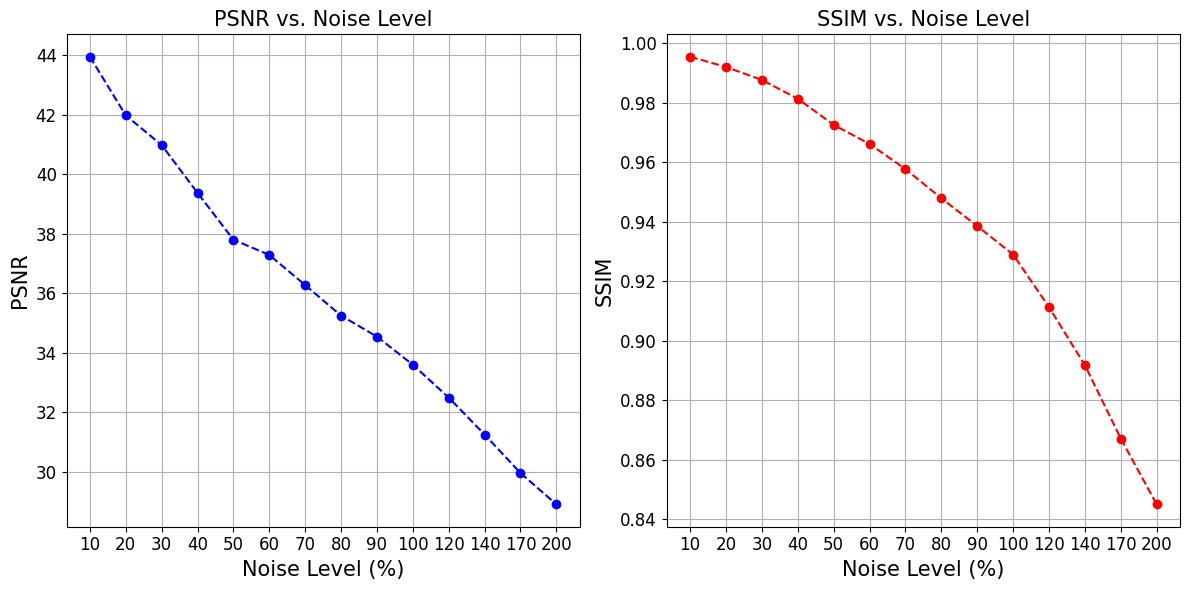

In [19]:
# 1. Grafici delle medie
plt.figure(figsize=(12, 6))

# Media PSNR
plt.subplot(1, 2, 1)
avg_psnr = [np.mean(off_psnr_results[noise]) for noise in off_psnr_results]
plt.plot(list(off_psnr_results.keys()), avg_psnr, 'o--', color='blue')
plt.xlabel('Noise Level (%)', fontsize=15)
plt.ylabel('PSNR', fontsize=15)
plt.title('PSNR vs. Noise Level', fontsize=15)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Media SSIM
plt.subplot(1, 2, 2)
avg_ssim = [np.mean(off_ssim_results[noise]) for noise in off_ssim_results]
plt.plot(list(off_ssim_results.keys()), avg_ssim, 'o--', color='red')
plt.xlabel('Noise Level (%)', fontsize=15)
plt.ylabel('SSIM', fontsize=15)
plt.title('SSIM vs. Noise Level', fontsize=15)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

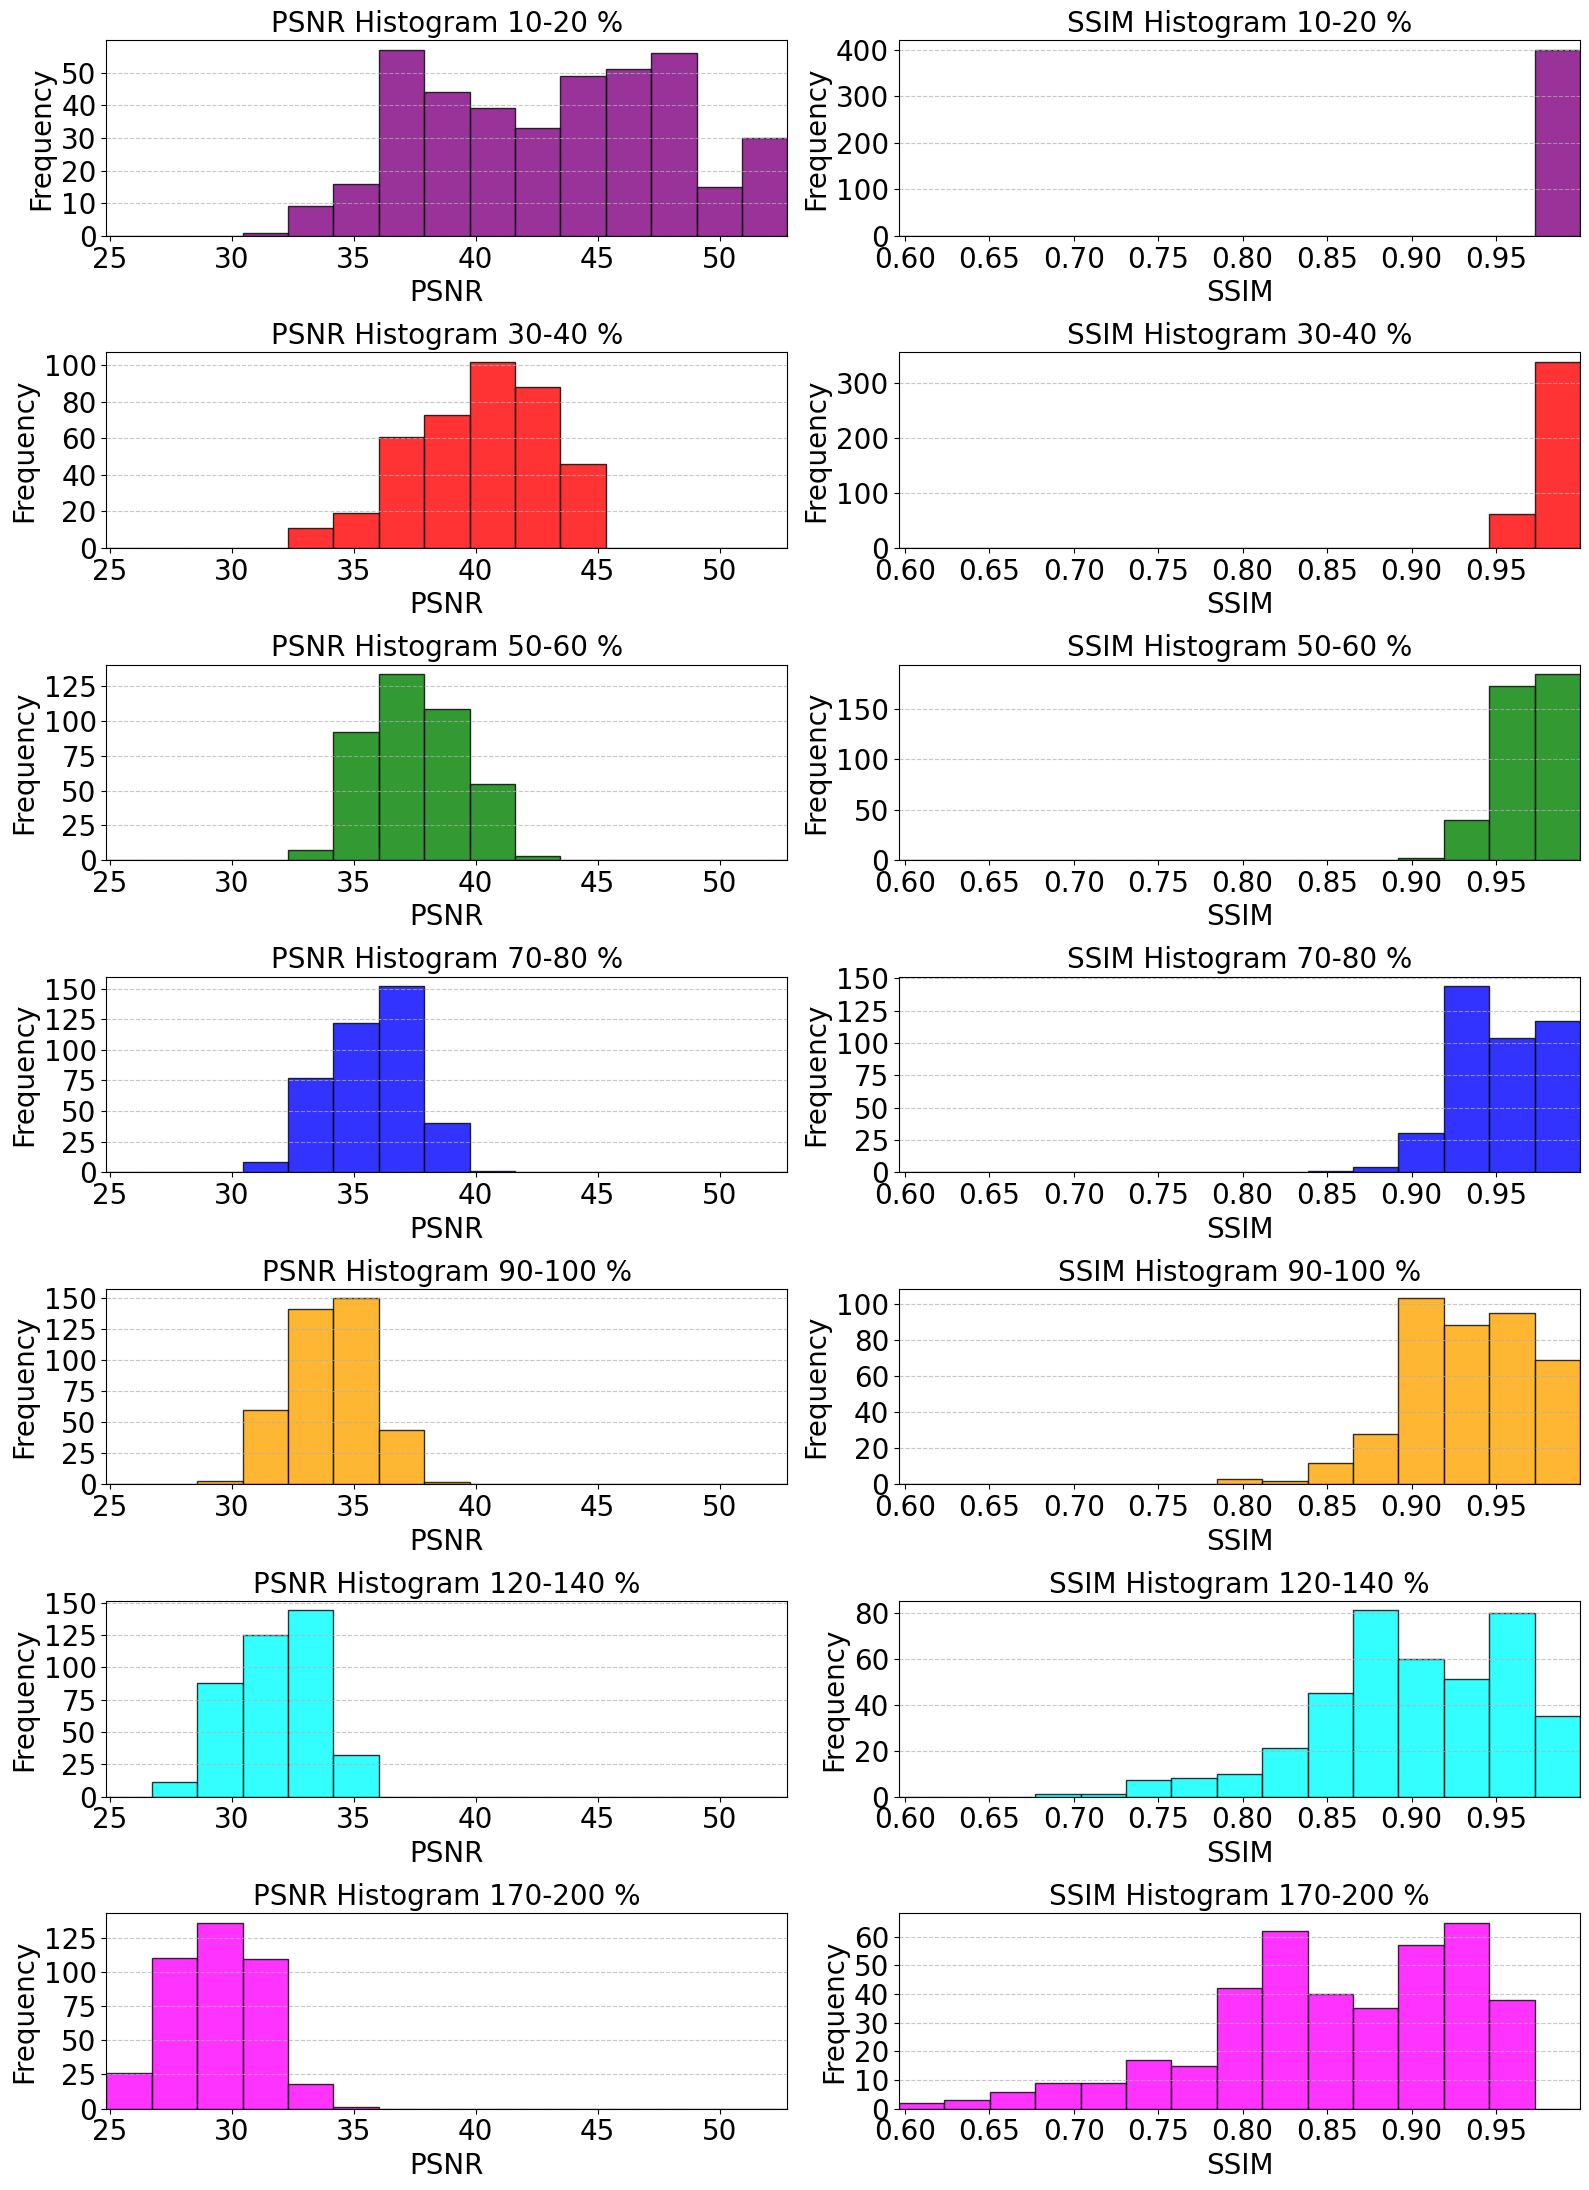

In [31]:
import matplotlib.pyplot as plt
import numpy as np

N_bins = 15

# Definizione dei gruppi di rumore
noise_groups = [
    ('10', '20'),
    ('30', '40'),
    ('50', '60'),
    ('70', '80'),
    ('90', '100'),
    ('120', '140'),
    ('170', '200')
]
colors = ['purple', 'red', 'green', 'blue', 'orange', 'cyan', 'magenta']

# Determinazione dei limiti comuni per gli assi x
psnr_min = min(min(off_psnr_results[noise]) for group in noise_groups for noise in group if noise)
psnr_max = max(max(off_psnr_results[noise]) for group in noise_groups for noise in group if noise)

ssim_min = min(min(off_ssim_results[noise]) for group in noise_groups for noise in group if noise)
ssim_max = max(max(off_ssim_results[noise]) for group in noise_groups for noise in group if noise)

# 2. Istogrammi affiancati (PSNR e SSIM)
plt.figure(figsize=(16, 22))  # Figura lunga e affiancata

for i, (group, color) in enumerate(zip(noise_groups, colors)):
    # Istogramma PSNR
    plt.subplot(len(noise_groups), 2, 2 * i + 1)
    combined_psnr = np.concatenate([off_psnr_results[noise] for noise in group if noise])
    counts, bin_edges = np.histogram(combined_psnr, bins=np.linspace(psnr_min, psnr_max, N_bins + 1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(
        bin_centers,
        counts,
        width=(bin_edges[1] - bin_edges[0]),
        color=color,
        edgecolor='black',
        alpha=0.8
    )
    noise_min = min(int(noise) for noise in group)
    noise_max = max(int(noise) for noise in group)
    plt.title(f'PSNR Histogram {noise_min}-{noise_max} %', fontsize=20)
    plt.xlabel('PSNR', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim(psnr_min, psnr_max)

    # Istogramma SSIM
    plt.subplot(len(noise_groups), 2, 2 * i + 2)
    combined_ssim = np.concatenate([off_ssim_results[noise] for noise in group if noise])
    counts, bin_edges = np.histogram(combined_ssim, bins=np.linspace(ssim_min, ssim_max, N_bins + 1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(
        bin_centers,
        counts,
        width=(bin_edges[1] - bin_edges[0]),
        color=color,
        edgecolor='black',
        alpha=0.8
    )
    plt.title(f'SSIM Histogram {noise_min}-{noise_max} %', fontsize=20)
    plt.xlabel('SSIM', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim(ssim_min, ssim_max)

plt.tight_layout()
plt.show()

# TA2

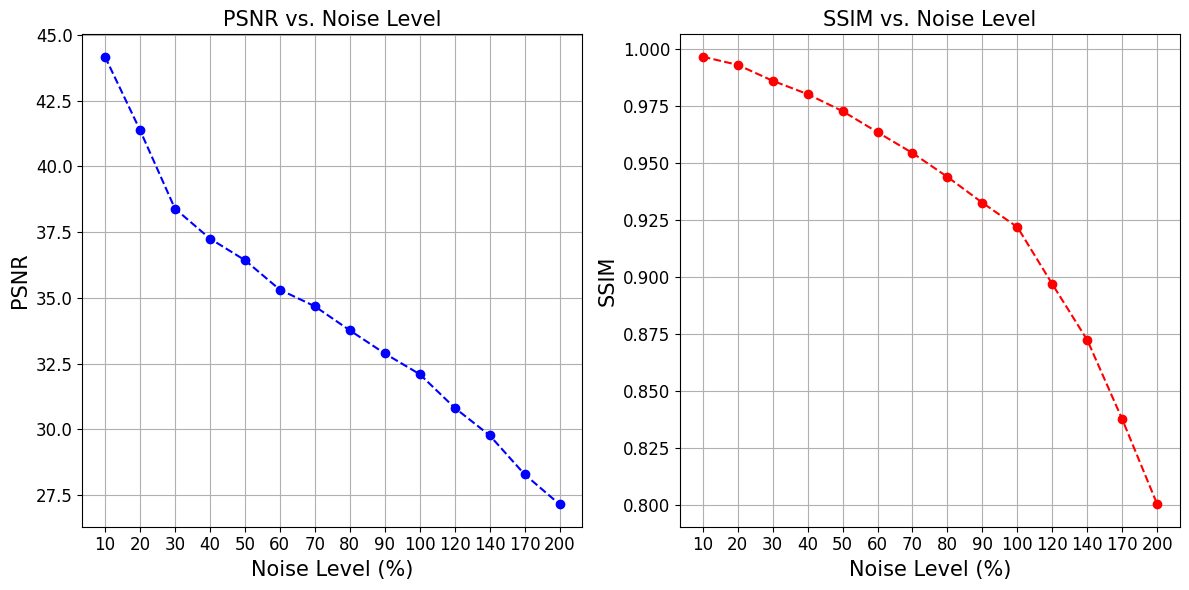

In [20]:
# 1. Grafici delle medie
plt.figure(figsize=(12, 6))

# Media PSNR
plt.subplot(1, 2, 1)
avg_psnr = [np.mean(ta2_psnr_results[noise]) for noise in ta2_psnr_results]
plt.plot(list(ta2_psnr_results.keys()), avg_psnr, 'o--', color='blue')
plt.xlabel('Noise Level (%)', fontsize=15)
plt.ylabel('PSNR', fontsize=15)
plt.title('PSNR vs. Noise Level', fontsize=15)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Media SSIM
plt.subplot(1, 2, 2)
avg_ssim = [np.mean(ta2_ssim_results[noise]) for noise in ta2_ssim_results]
plt.plot(list(ta2_ssim_results.keys()), avg_ssim, 'o--', color='red')
plt.xlabel('Noise Level (%)', fontsize=15)
plt.ylabel('SSIM', fontsize=15)
plt.title('SSIM vs. Noise Level', fontsize=15)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

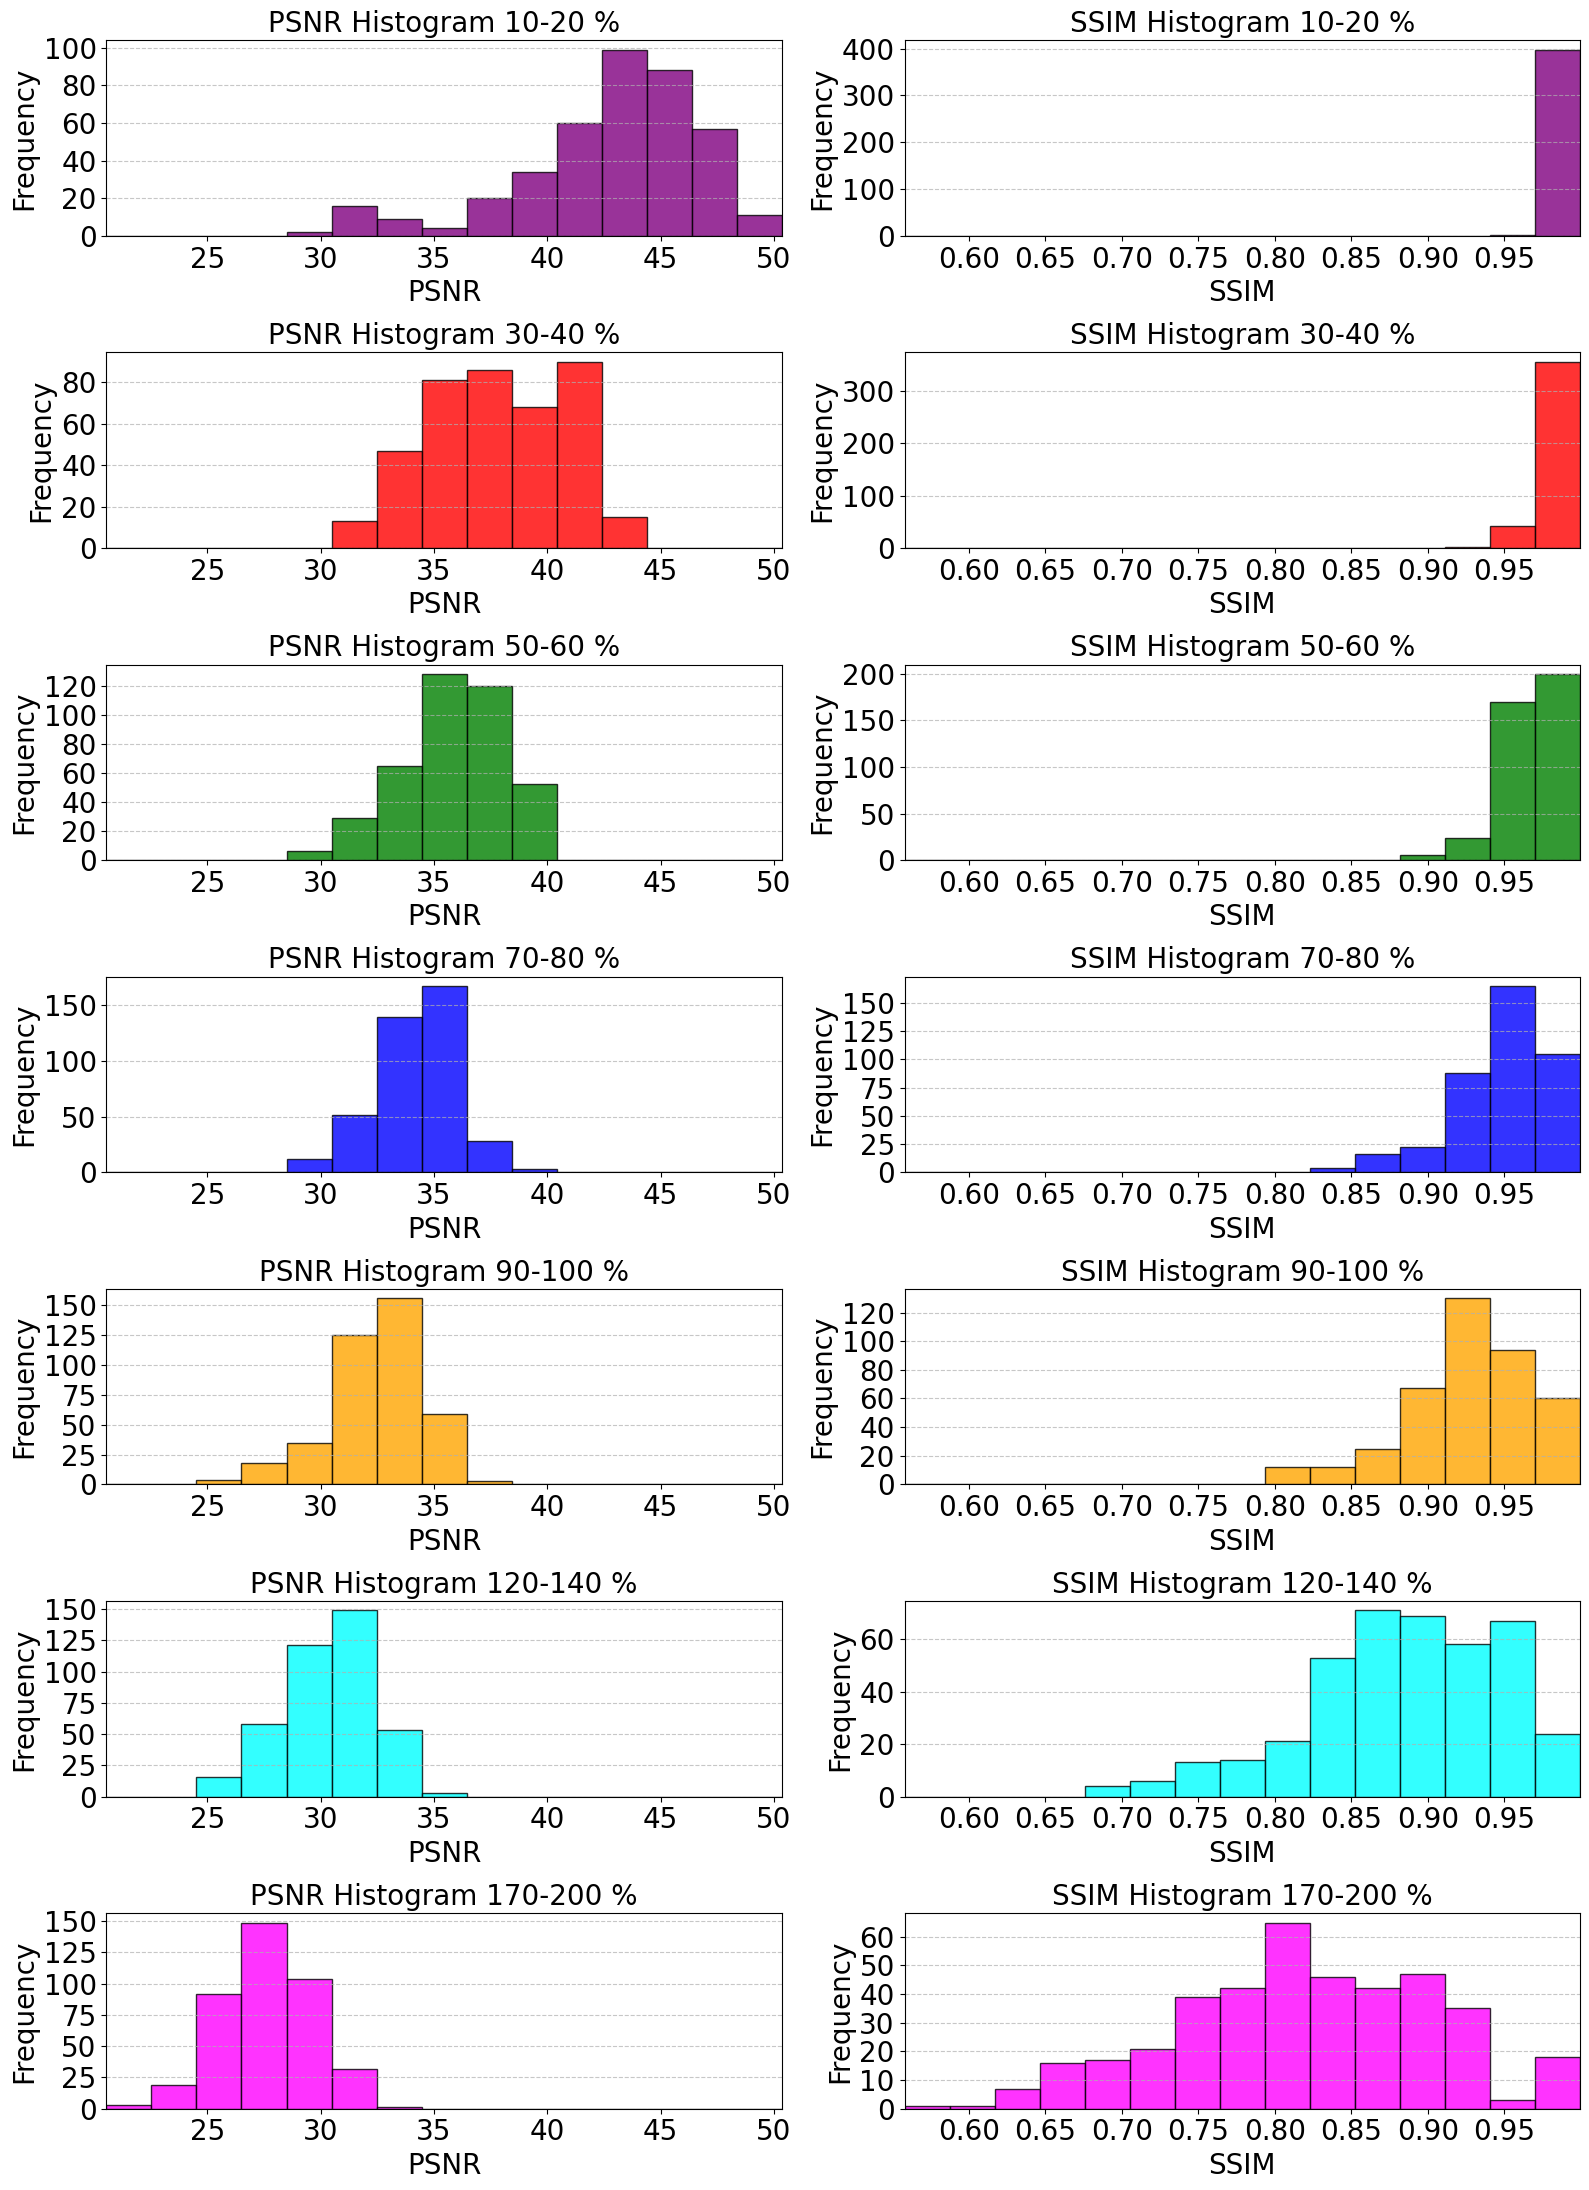

In [32]:
import matplotlib.pyplot as plt
import numpy as np

N_bins = 15

# Definizione dei gruppi di rumore
noise_groups = [
    ('10', '20'),
    ('30', '40'),
    ('50', '60'),
    ('70', '80'),
    ('90', '100'),
    ('120', '140'),
    ('170', '200')
]
colors = ['purple', 'red', 'green', 'blue', 'orange', 'cyan', 'magenta']

# Determinazione dei limiti comuni per gli assi x
psnr_min = min(min(ta2_psnr_results[noise]) for group in noise_groups for noise in group if noise)
psnr_max = max(max(ta2_psnr_results[noise]) for group in noise_groups for noise in group if noise)

ssim_min = min(min(ta2_ssim_results[noise]) for group in noise_groups for noise in group if noise)
ssim_max = max(max(ta2_ssim_results[noise]) for group in noise_groups for noise in group if noise)

# 2. Istogrammi affiancati (PSNR e SSIM)
plt.figure(figsize=(16, 22))  # Figura lunga e affiancata

for i, (group, color) in enumerate(zip(noise_groups, colors)):
    # Istogramma PSNR
    plt.subplot(len(noise_groups), 2, 2 * i + 1)
    combined_psnr = np.concatenate([ta2_psnr_results[noise] for noise in group if noise])
    counts, bin_edges = np.histogram(combined_psnr, bins=np.linspace(psnr_min, psnr_max, N_bins + 1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(
        bin_centers,
        counts,
        width=(bin_edges[1] - bin_edges[0]),
        color=color,
        edgecolor='black',
        alpha=0.8
    )
    noise_min = min(int(noise) for noise in group)
    noise_max = max(int(noise) for noise in group)
    plt.title(f'PSNR Histogram {noise_min}-{noise_max} %', fontsize=20)
    plt.xlabel('PSNR', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim(psnr_min, psnr_max)

    # Istogramma SSIM
    plt.subplot(len(noise_groups), 2, 2 * i + 2)
    combined_ssim = np.concatenate([ta2_ssim_results[noise] for noise in group if noise])
    counts, bin_edges = np.histogram(combined_ssim, bins=np.linspace(ssim_min, ssim_max, N_bins + 1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(
        bin_centers,
        counts,
        width=(bin_edges[1] - bin_edges[0]),
        color=color,
        edgecolor='black',
        alpha=0.8
    )
    plt.title(f'SSIM Histogram {noise_min}-{noise_max} %', fontsize=20)
    plt.xlabel('SSIM', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim(ssim_min, ssim_max)

plt.tight_layout()
plt.show()

# TA1&2

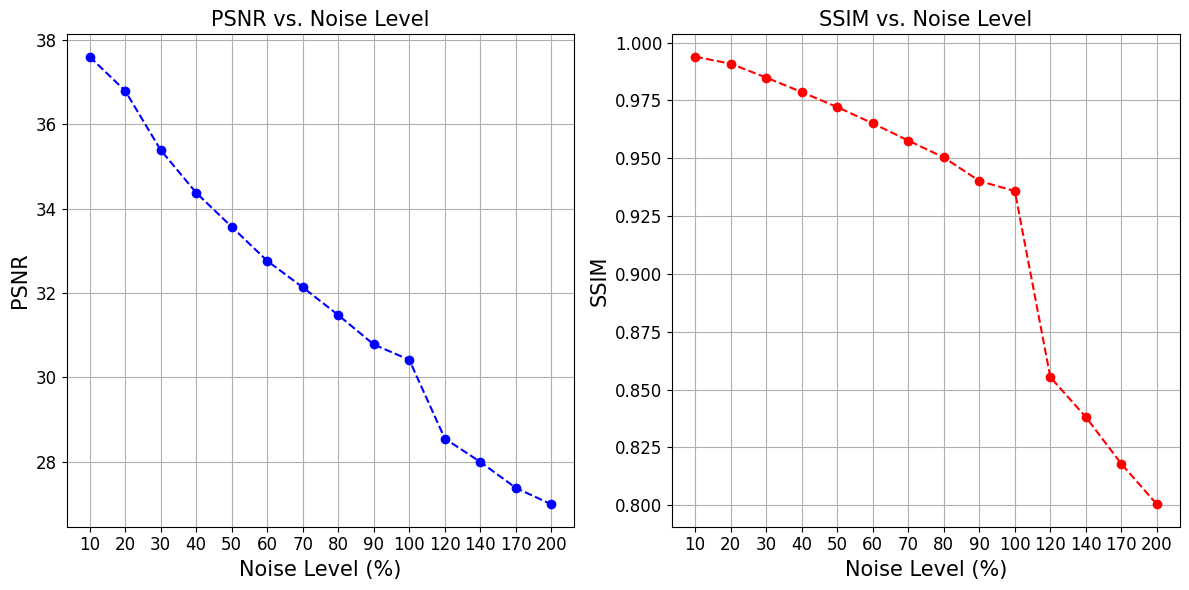

In [22]:
# 1. Grafici delle medie
plt.figure(figsize=(12, 6))

# Media PSNR
plt.subplot(1, 2, 1)
avg_psnr = [np.mean(ta1and2_psnr_results[noise]) for noise in ta1and2_psnr_results]
plt.plot(list(ta1and2_psnr_results.keys()), avg_psnr, 'o--', color='blue')
plt.xlabel('Noise Level (%)', fontsize=15)
plt.ylabel('PSNR', fontsize=15)
plt.title('PSNR vs. Noise Level', fontsize=15)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Media SSIM
plt.subplot(1, 2, 2)
avg_ssim = [np.mean(ta1and2_ssim_results[noise]) for noise in ta1and2_ssim_results]
plt.plot(list(ta1and2_ssim_results.keys()), avg_ssim, 'o--', color='red')
plt.xlabel('Noise Level (%)', fontsize=15)
plt.ylabel('SSIM', fontsize=15)
plt.title('SSIM vs. Noise Level', fontsize=15)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

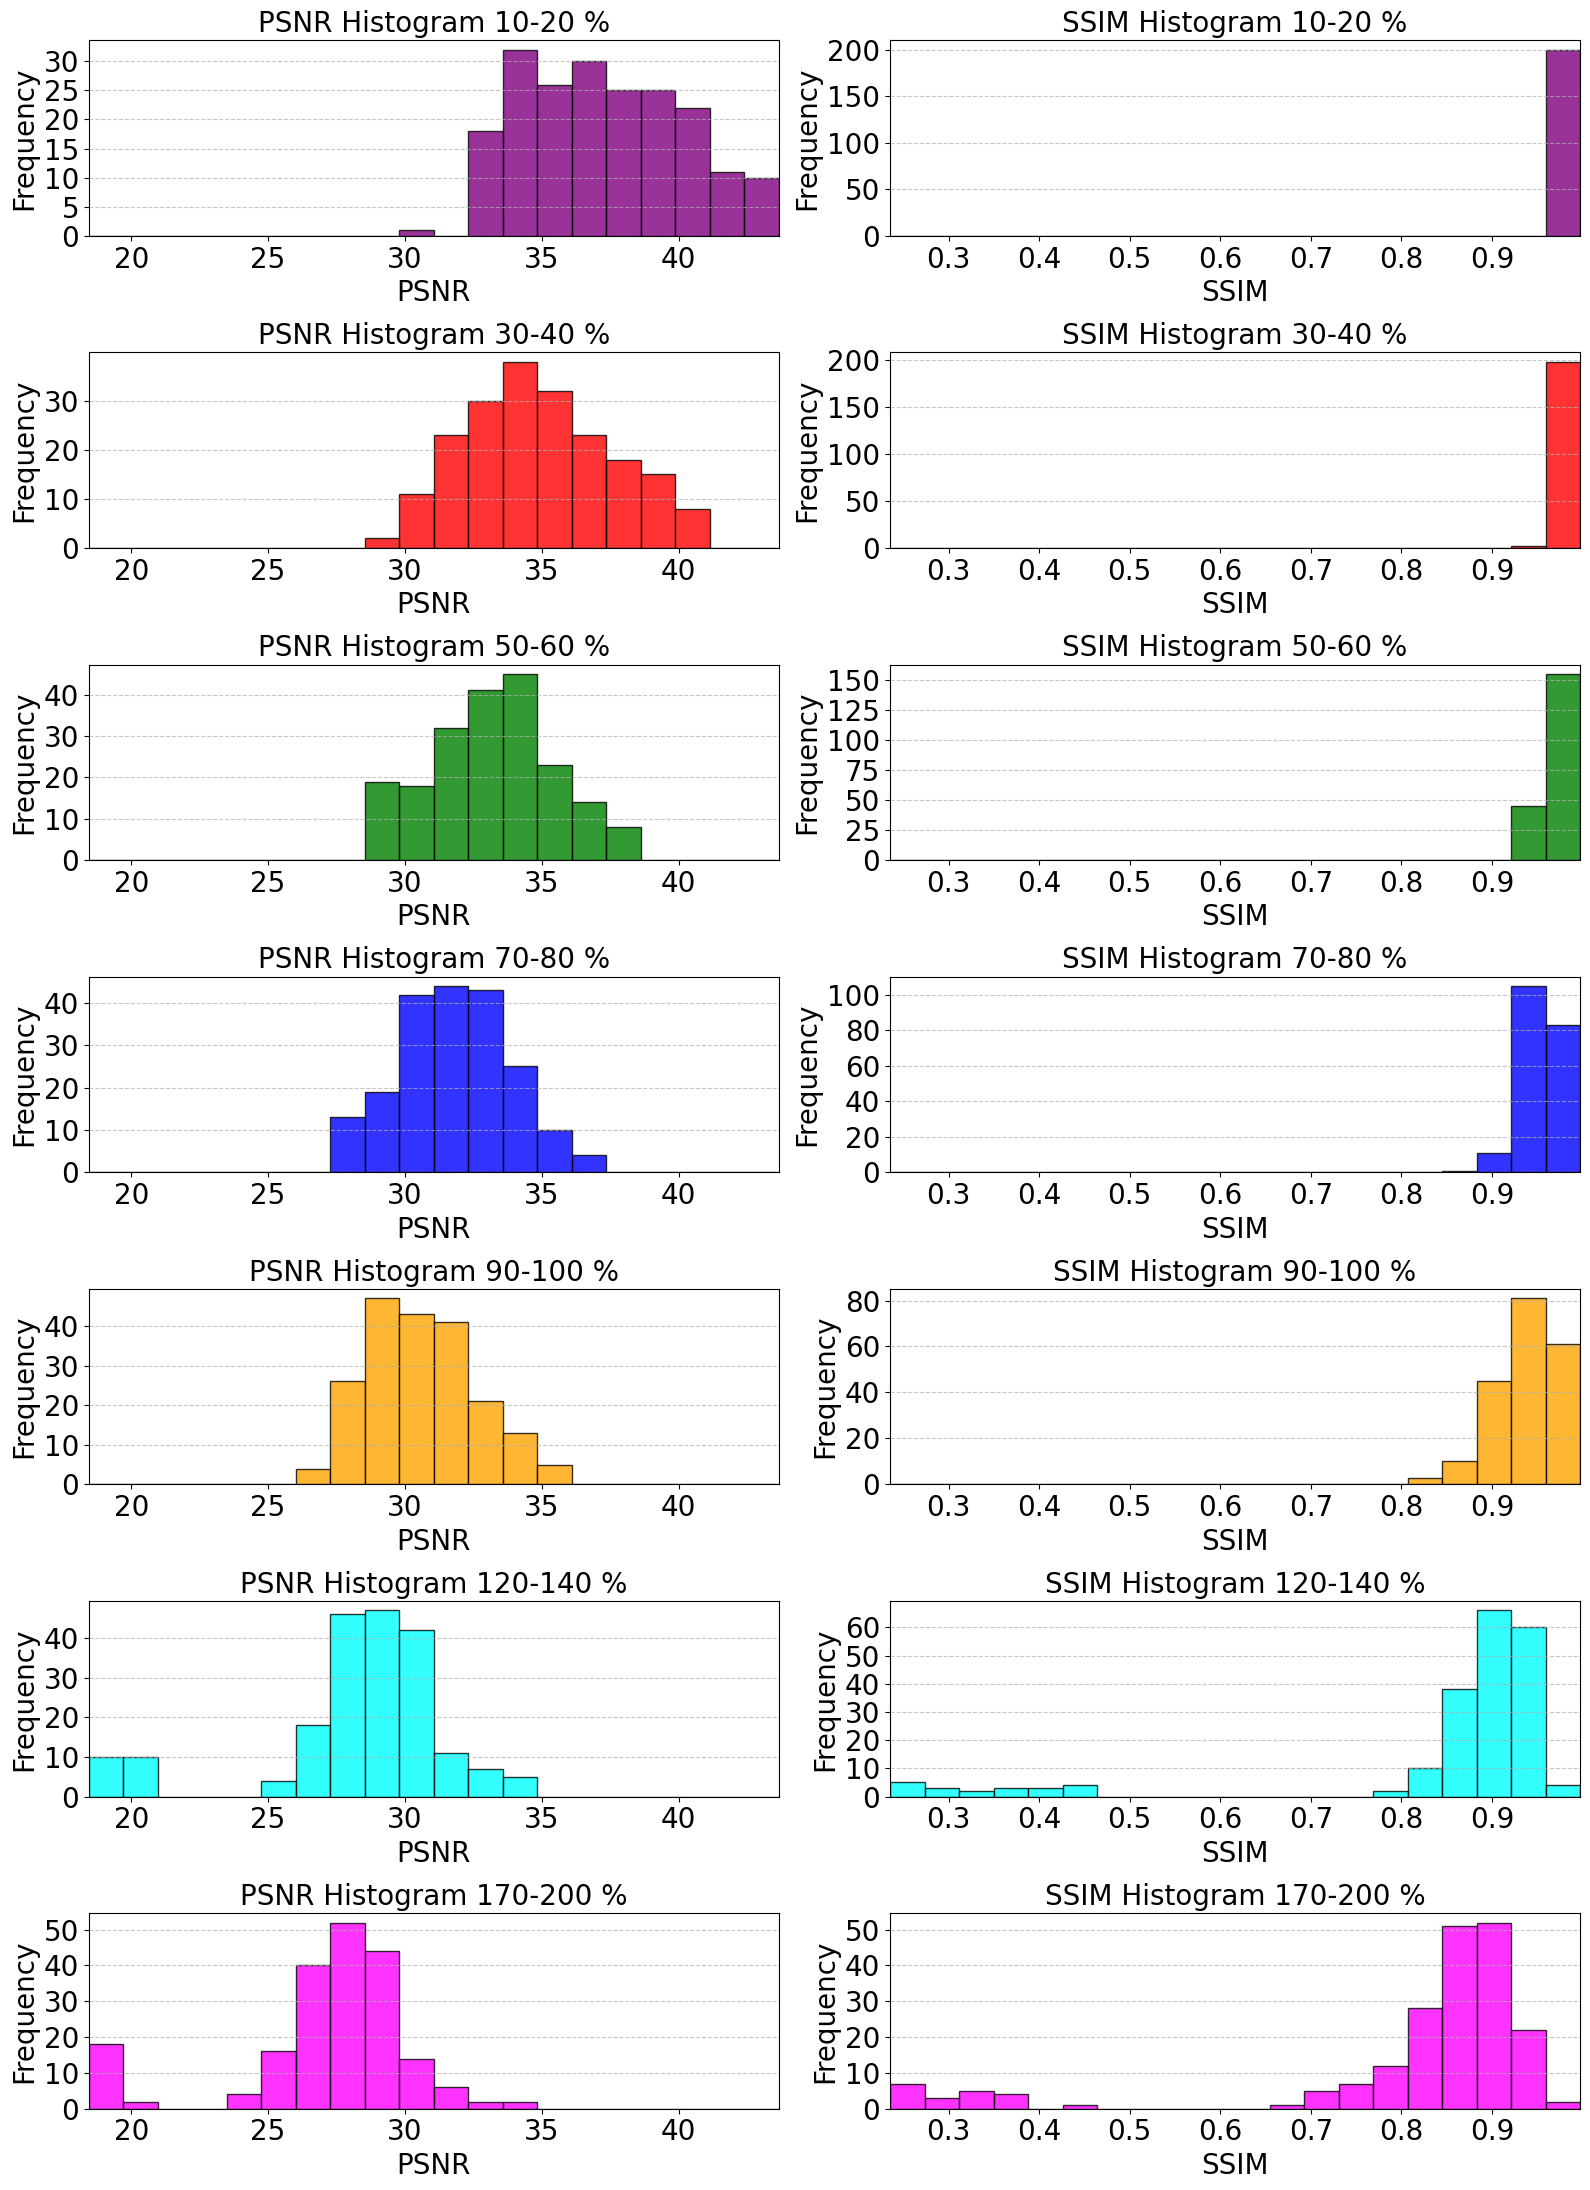

In [36]:
import matplotlib.pyplot as plt
import numpy as np

N_bins = 20

# Definizione dei gruppi di rumore
noise_groups = [
    ('10', '20'),
    ('30', '40'),
    ('50', '60'),
    ('70', '80'),
    ('90', '100'),
    ('120', '140'),
    ('170', '200')
]
colors = ['purple', 'red', 'green', 'blue', 'orange', 'cyan', 'magenta']

# Determinazione dei limiti comuni per gli assi x
psnr_min = min(min(ta1and2_psnr_results[noise]) for group in noise_groups for noise in group if noise)
psnr_max = max(max(ta1and2_psnr_results[noise]) for group in noise_groups for noise in group if noise)

ssim_min = min(min(ta1and2_ssim_results[noise]) for group in noise_groups for noise in group if noise)
ssim_max = max(max(ta1and2_ssim_results[noise]) for group in noise_groups for noise in group if noise)

# 2. Istogrammi affiancati (PSNR e SSIM)
plt.figure(figsize=(16, 22))  # Figura lunga e affiancata

for i, (group, color) in enumerate(zip(noise_groups, colors)):
    # Istogramma PSNR
    plt.subplot(len(noise_groups), 2, 2 * i + 1)
    combined_psnr = np.concatenate([ta1and2_psnr_results[noise] for noise in group if noise])
    counts, bin_edges = np.histogram(combined_psnr, bins=np.linspace(psnr_min, psnr_max, N_bins + 1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(
        bin_centers,
        counts,
        width=(bin_edges[1] - bin_edges[0]),
        color=color,
        edgecolor='black',
        alpha=0.8
    )
    noise_min = min(int(noise) for noise in group)
    noise_max = max(int(noise) for noise in group)
    plt.title(f'PSNR Histogram {noise_min}-{noise_max} %', fontsize=20)
    plt.xlabel('PSNR', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim(psnr_min, psnr_max)

    # Istogramma SSIM
    plt.subplot(len(noise_groups), 2, 2 * i + 2)
    combined_ssim = np.concatenate([ta1and2_ssim_results[noise] for noise in group if noise])
    counts, bin_edges = np.histogram(combined_ssim, bins=np.linspace(ssim_min, ssim_max, N_bins + 1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(
        bin_centers,
        counts,
        width=(bin_edges[1] - bin_edges[0]),
        color=color,
        edgecolor='black',
        alpha=0.8
    )
    plt.title(f'SSIM Histogram {noise_min}-{noise_max} %', fontsize=20)
    plt.xlabel('SSIM', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim(ssim_min, ssim_max)

plt.tight_layout()
plt.show()

In [7]:
#assieme

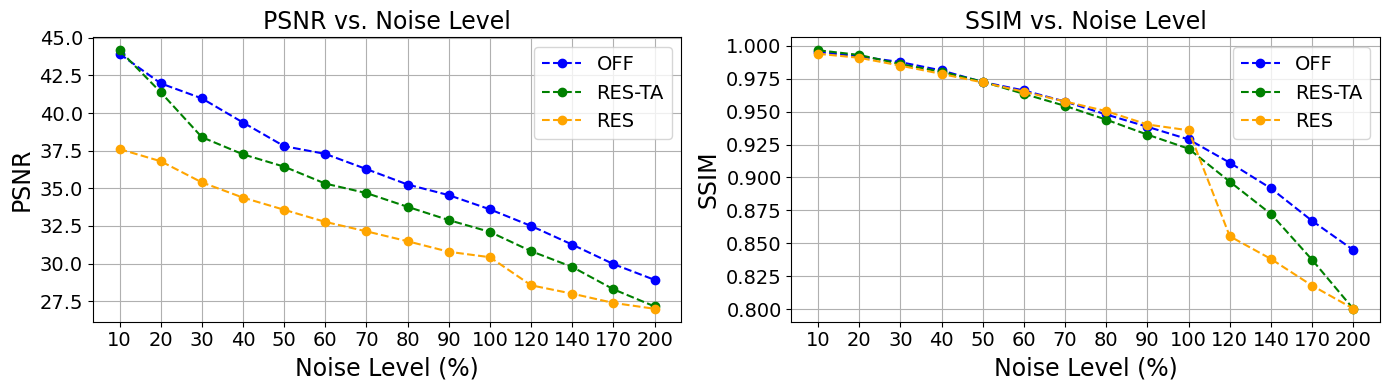

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Supponendo che i risultati siano definiti come segue:
# off_psnr_results, off_ssim_results
# ta2_psnr_results, ta2_ssim_results
# ta1and2_psnr_results, ta1and2_ssim_results

# Creazione della figura
plt.figure(figsize=(14, 4))

# Subplot 1: PSNR
plt.subplot(1, 2, 1)

# OFF PSNR
avg_psnr_off = [np.mean(off_psnr_results[noise]) for noise in off_psnr_results]
plt.plot(list(off_psnr_results.keys()), avg_psnr_off, 'o--', label='OFF', color='blue')

# TA2 PSNR
avg_psnr_ta2 = [np.mean(ta2_psnr_results[noise]) for noise in ta2_psnr_results]
plt.plot(list(ta2_psnr_results.keys()), avg_psnr_ta2, 'o--', label='RES-TA', color='green')

# TA1 and TA2 PSNR
avg_psnr_ta1and2 = [np.mean(ta1and2_psnr_results[noise]) for noise in ta1and2_psnr_results]
plt.plot(list(ta1and2_psnr_results.keys()), avg_psnr_ta1and2, 'o--', label='RES', color='orange')

plt.xlabel('Noise Level (%)', fontsize=17)
plt.ylabel('PSNR', fontsize=17)
plt.title('PSNR vs. Noise Level', fontsize=17)
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Subplot 2: SSIM
plt.subplot(1, 2, 2)

# OFF SSIM
avg_ssim_off = [np.mean(off_ssim_results[noise]) for noise in off_ssim_results]
plt.plot(list(off_ssim_results.keys()), avg_ssim_off, 'o--', label='OFF', color='blue')

# TA2 SSIM
avg_ssim_ta2 = [np.mean(ta2_ssim_results[noise]) for noise in ta2_ssim_results]
plt.plot(list(ta2_ssim_results.keys()), avg_ssim_ta2, 'o--', label='RES-TA', color='green')

# TA1 and TA2 SSIM
avg_ssim_ta1and2 = [np.mean(ta1and2_ssim_results[noise]) for noise in ta1and2_ssim_results]
plt.plot(list(ta1and2_ssim_results.keys()), avg_ssim_ta1and2, 'o--', label='RES', color='orange')

plt.xlabel('Noise Level (%)', fontsize=17)
plt.ylabel('SSIM', fontsize=17)
plt.title('SSIM vs. Noise Level', fontsize=17)
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Layout finale
plt.tight_layout()
plt.show()

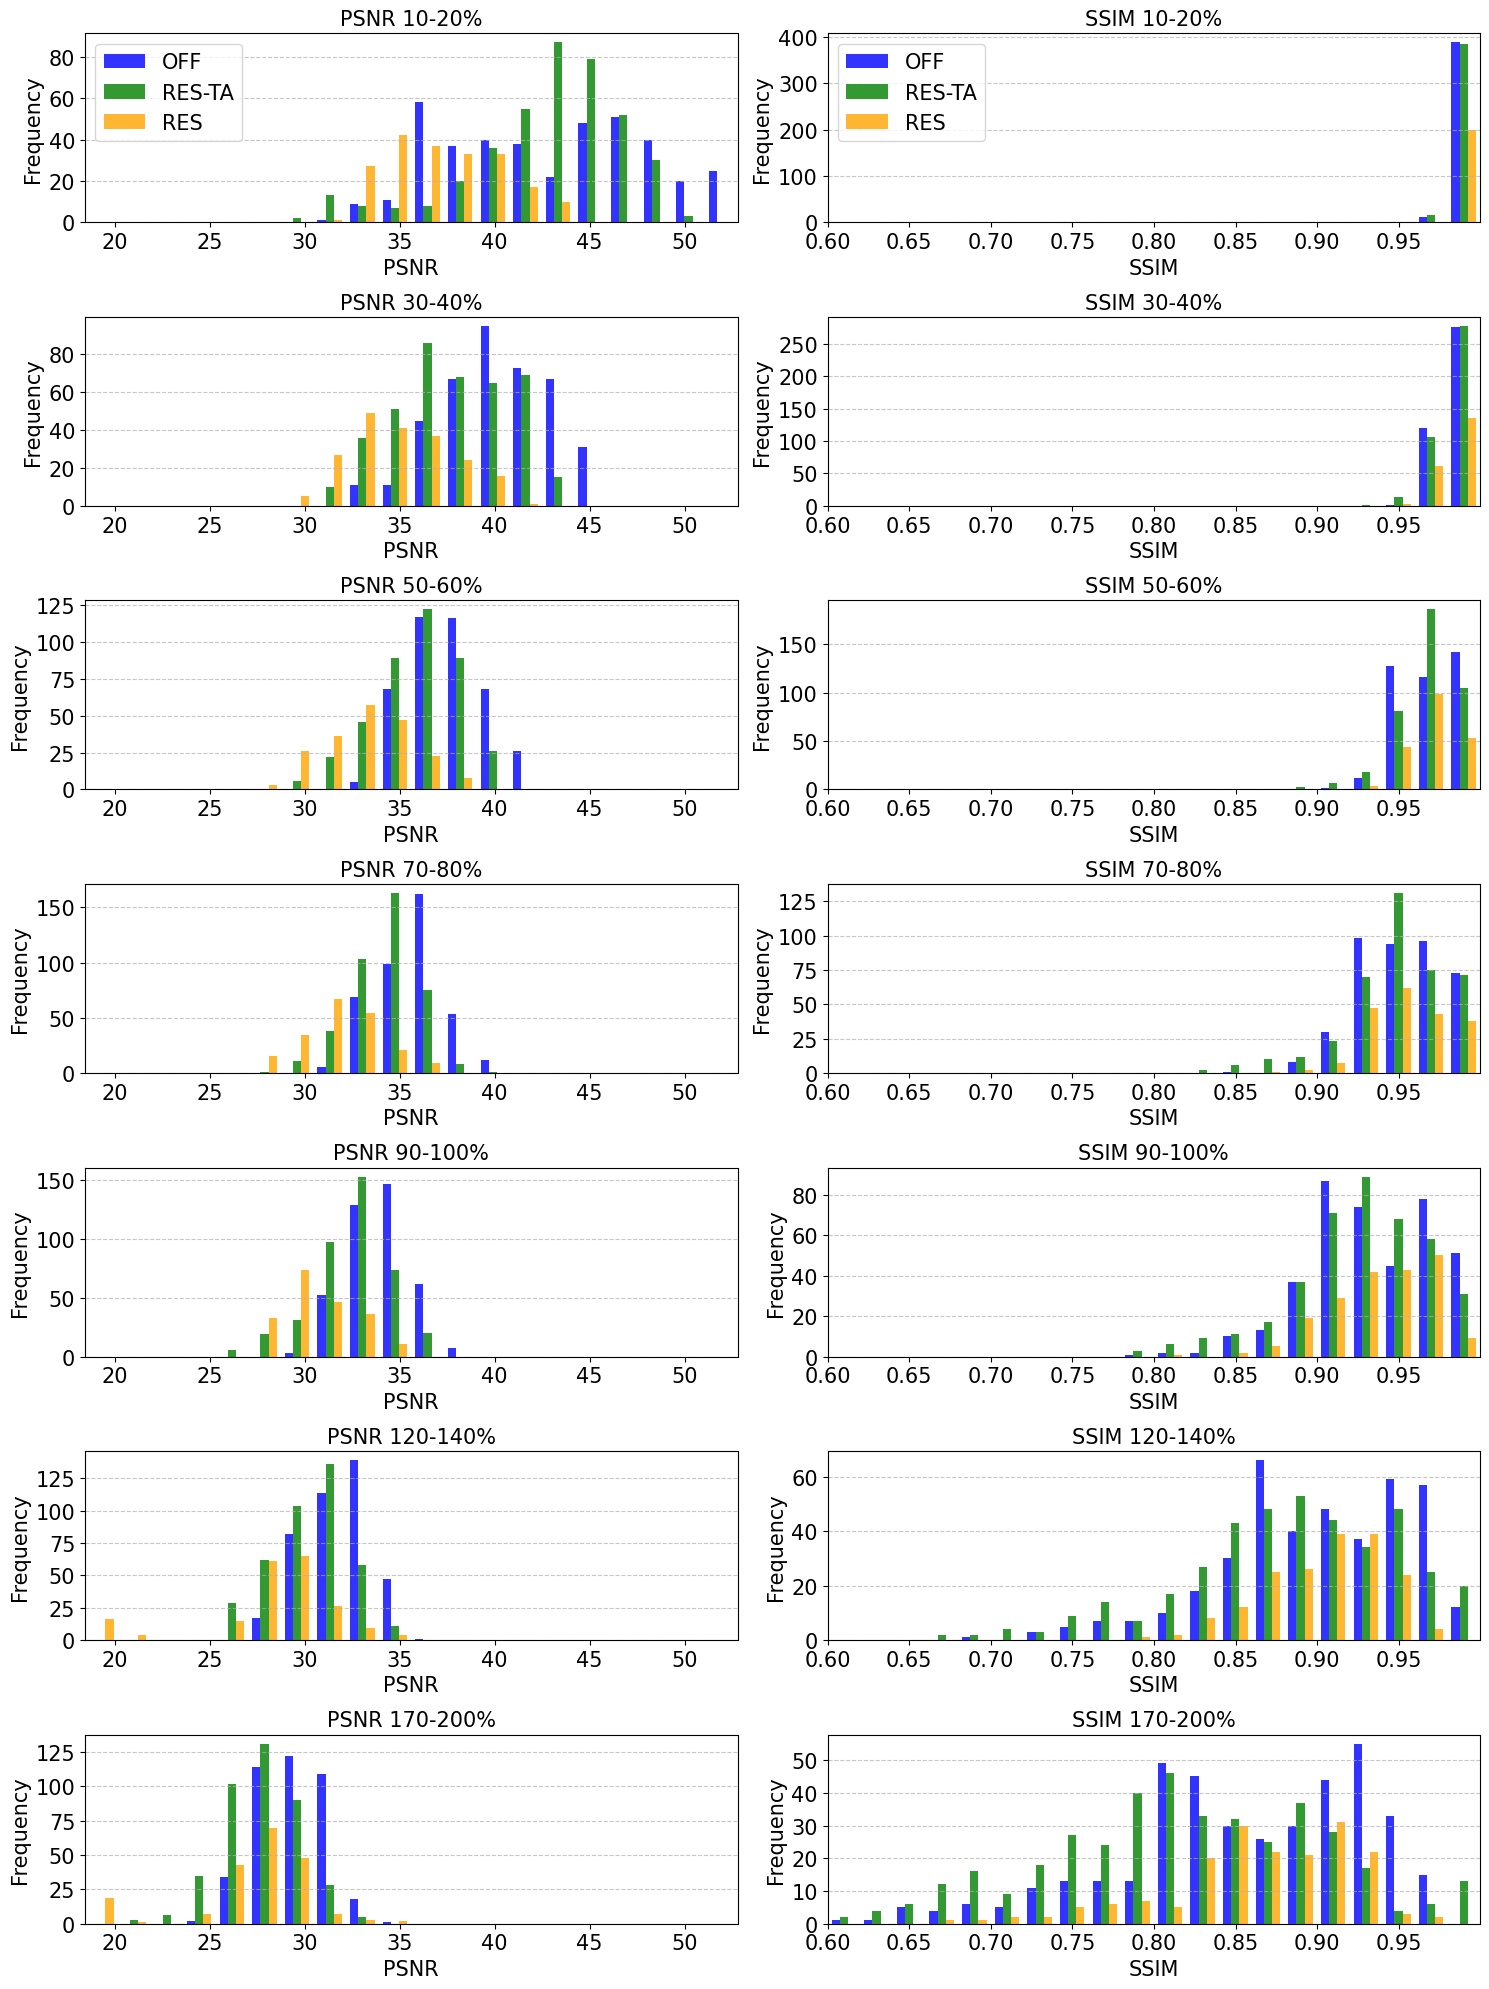

In [11]:
import matplotlib.pyplot as plt
import numpy as np

N_bins = 20

# Definizione dei gruppi di rumore
noise_groups = [
    ('10', '20'),
    ('30', '40'),
    ('50', '60'),
    ('70', '80'),
    ('90', '100'),
    ('120', '140'),
    ('170', '200')
]

# Determinazione dei limiti comuni per gli assi x (PSNR e SSIM)
psnr_min = min(
    min(min(results[noise]) for noise in group if noise)
    for results in [off_psnr_results, ta2_psnr_results, ta1and2_psnr_results]
    for group in noise_groups
)
psnr_max = max(
    max(max(results[noise]) for noise in group if noise)
    for results in [off_psnr_results, ta2_psnr_results, ta1and2_psnr_results]
    for group in noise_groups
)

ssim_min = 0.6#min(
    #min(min(results[noise]) for noise in group if noise)
    #for results in [off_ssim_results, ta2_ssim_results, ta1and2_ssim_results]
    #for group in noise_groups
#)
ssim_max = max(
    max(max(results[noise]) for noise in group if noise)
    for results in [off_ssim_results, ta2_ssim_results, ta1and2_ssim_results]
    for group in noise_groups
)

# Funzione per disegnare un istogramma multi-bar
def plot_multihist(data_off, data_ta2, data_ta1and2, bins, title, xlabel, ylabel, xlim, group_index):
    bin_edges = np.linspace(xlim[0], xlim[1], bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Centri delle barre
    width = (bin_edges[1] - bin_edges[0]) / 4  # Larghezza delle barre

    # Conteggio delle frequenze per ciascun metodo
    freq_off, _ = np.histogram(data_off, bins=bin_edges)
    freq_ta2, _ = np.histogram(data_ta2, bins=bin_edges)
    freq_ta1and2, _ = np.histogram(data_ta1and2, bins=bin_edges)

    # Grafico delle barre
    plt.bar(bin_centers - width, freq_off, width=width, color='blue', alpha=0.8, label='OFF')
    plt.bar(bin_centers, freq_ta2, width=width, color='green', alpha=0.8, label='RES-TA')
    plt.bar(bin_centers + width, freq_ta1and2, width=width, color='orange', alpha=0.8, label='RES')

    # Dettagli del grafico
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlim(xlim)
    if group_index == 0:  # Aggiungi legenda solo nel primo pannello
        plt.legend(fontsize=15)

# Figura per i grafici
plt.figure(figsize=(15, 20))  # Figura grande per adattare tutto

for i, group in enumerate(noise_groups):
    noise_min = min(int(noise) for noise in group)
    noise_max = max(int(noise) for noise in group)

    # Creazione dei dati combinati per i tre metodi
    combined_psnr_off = np.concatenate([off_psnr_results[noise] for noise in group if noise])
    combined_psnr_ta2 = np.concatenate([ta2_psnr_results[noise] for noise in group if noise])
    combined_psnr_ta1and2 = np.concatenate([ta1and2_psnr_results[noise] for noise in group if noise])

    combined_ssim_off = np.concatenate([off_ssim_results[noise] for noise in group if noise])
    combined_ssim_ta2 = np.concatenate([ta2_ssim_results[noise] for noise in group if noise])
    combined_ssim_ta1and2 = np.concatenate([ta1and2_ssim_results[noise] for noise in group if noise])

    # PSNR Multihist
    plt.subplot(len(noise_groups), 2, 2 * i + 1)
    plot_multihist(
        combined_psnr_off, combined_psnr_ta2, combined_psnr_ta1and2, N_bins,
        title=f'PSNR {noise_min}-{noise_max}%', xlabel='PSNR', ylabel='Frequency',
        xlim=(psnr_min, psnr_max), group_index=i
    )

    # SSIM Multihist
    plt.subplot(len(noise_groups), 2, 2 * i + 2)
    plot_multihist(
        combined_ssim_off, combined_ssim_ta2, combined_ssim_ta1and2, N_bins,
        title=f'SSIM {noise_min}-{noise_max}%', xlabel='SSIM', ylabel='Frequency',
        xlim=(ssim_min, ssim_max), group_index=i
    )

plt.tight_layout()
plt.show()


In [ ]:
# gray coso

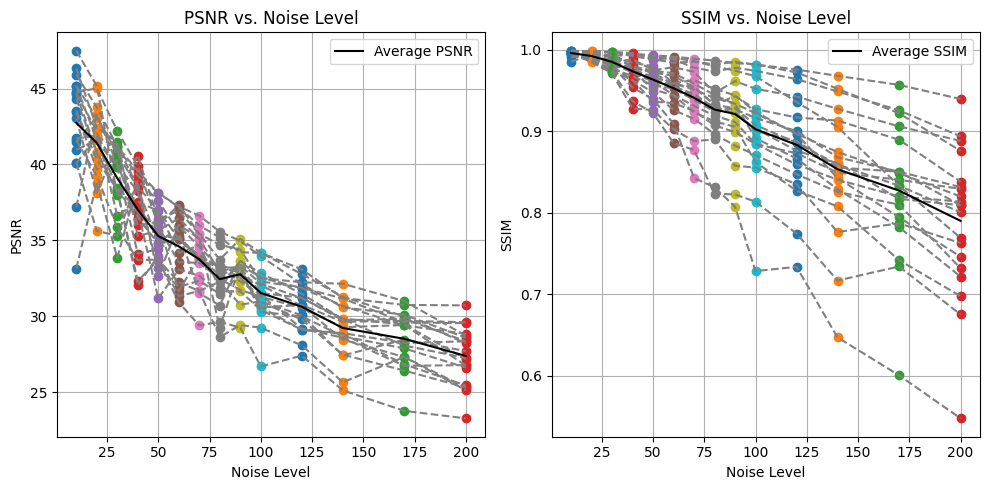

In [200]:
# Trova il numero di punti per ciascun livello di rumore (assumendo che siano uguali per ogni livello)
num_points = len(next(iter(psnr_results.values())))

# Plot PSNR e SSIM per ogni livello di rumore
plt.figure(figsize=(10, 5))

# Plot PSNR
plt.subplot(1, 2, 1)
for noise in psnr_results:
    plt.plot([noise] * num_points, psnr_results[noise], 'o')  # Punti PSNR per ogni livello di rumore
# Collegare i punti per indice
for idx in range(num_points):
    plt.plot(list(psnr_results.keys()), [psnr_results[noise][idx] for noise in psnr_results], '--', color='gray')  # Linea per ciascun indice
# Media PSNR per ogni livello di rumore
avg_psnr = [np.mean(psnr_results[noise]) for noise in psnr_results]
plt.plot(list(psnr_results.keys()), avg_psnr, 'k-', label="Average PSNR")  # Linea nera per media PSNR
plt.xlabel('Noise Level')
plt.ylabel('PSNR')
plt.title('PSNR vs. Noise Level')
plt.legend()
plt.grid()

# Plot SSIM
plt.subplot(1, 2, 2)
for noise in ssim_results:
    plt.plot([noise] * num_points, ssim_results[noise], 'o')  # Punti SSIM per ogni livello di rumore
# Collegare i punti per indice
for idx in range(num_points):
    plt.plot(list(ssim_results.keys()), [ssim_results[noise][idx] for noise in ssim_results], '--', color='gray')  # Linea per ciascun indice
# Media SSIM per ogni livello di rumore
avg_ssim = [np.mean(ssim_results[noise]) for noise in ssim_results]
plt.plot(list(ssim_results.keys()), avg_ssim, 'k-', label="Average SSIM")  # Linea nera per media SSIM
plt.xlabel('Noise Level')
plt.ylabel('SSIM')
plt.title('SSIM vs. Noise Level')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
